In [2]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2


import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
import utils
import plotting

import os


Bad key "text.kerning_factor" on line 4 in
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


## Create ISORROPIA Input

In [3]:
#import HEMCO emissions files and choose the first level, combine into one dataset
ds_nonuc = xr.open_zarr('./pm_nonuc_ds.zarr')
ds_normal = xr.open_zarr('../model_validation/pm_ds.zarr')
ds_normal = ds_normal.sel(model_name = 'MODEL').drop('model_name')
ds = xr.concat([ds_nonuc, ds_normal], pd.Index(['no_nuclear', 'normal'], name='model_name'))

#import RH and T dataframe
RH_T_df = pd.read_csv('RH_T.csv', index_col=[0,1])

#subset our ds into just the species we need
species_list = ['SO4','NH3','HNO3','NIT','NH4']
isorropia_ds = ds[species_list]

SO4, NH3, NO3, Cl, Ca, K, Mg

In [4]:
#create a dataframe for our isorropia monthly mean values for no nuclear and normal cases, indexed by species, location, season

isorropia_dict = {}
for species in species_list:
    isorropia_dict[species]= {}
    for region in utils.lat_lon_dict.keys():
        isorropia_dict[species][region] = {}
        for season in ['DJF','MAM','JJA','SON']:
            data = isorropia_ds.sel(lon = slice(utils.lat_lon_dict[region][0], utils.lat_lon_dict[region][1]), 
                                    lat = slice(utils.lat_lon_dict[region][2],utils.lat_lon_dict[region][3])).groupby('time.season').mean(dim = ['lat','lon','time']).sel(season = season)[species]
            isorropia_dict[species][region][season] = data.values
            
isorropia_df = pd.DataFrame.from_dict({(i,j,k): isorropia_dict[i][j][k] 
                            for i in isorropia_dict.keys() 
                            for j in isorropia_dict[i].keys()
                            for k in isorropia_dict[i][j].keys()},
                            orient='index', columns = ['no_nuclear','normal'])

isorropia_df.index = pd.MultiIndex.from_tuples(isorropia_df.index, names = ['Species','Location', 'Season'])

In [5]:
#convert from mol/mol to mol/m3 by multiplying by P/T*R (mol/m3)
stp_p = 101325 #Pa = kg/m/s^2
R = 8.314 #J/K/mol
isorropia_df['no_nuclear_2x'] = '0'
for species in species_list:
    for region in utils.lat_lon_dict.keys():
            for season in ['DJF','MAM','JJA','SON']:
                isorropia_df.loc[(species,region,season)]['no_nuclear'] *= stp_p/R/RH_T_df.loc[(region,season)]['T']
                isorropia_df.loc[(species,region,season)]['normal'] *= stp_p/R/RH_T_df.loc[(region,season)]['T']


/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/emfreese/anaconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
#calculate the total Nitrate and ammonium by molarity
isorropia_df_TNO3 = isorropia_df.loc['HNO3'] + isorropia_df.loc['NIT'] 
isorropia_df_TNH3 = isorropia_df.loc['NH3'] + isorropia_df.loc['NH4'] 

## Run through ISORROPIA
### Only run once to initiate a new ISORROPIA output, otherwise, the output is already made

os.chdir('../../ISORROPIAIIStandalone')
for model in ['no_nuclear', 'normal']:
    for region in ['SE_lat_lon', 'NW_lat_lon', 'NE_lat_lon', 'MW_lat_lon', 'SW_lat_lon']:
            for season in ['DJF','JJA']:
                T_tmp = RH_T_df.loc[(region, season)]['T']
                RH_tmp = RH_T_df.loc[(region, season)]['RH']
                SO4_tmp = isorropia_df.loc['SO4',region,season][model]
                
                os.system(f'mkdir -p {region}_{season}_{model}/')
                os.system(f'cp src/* {region}_{season}_{model}/')
                
                os.chdir(f'{region}_{season}_{model}/')
                print(os.listdir())
                
                cmdprefix = 'cat ISORange.dat | sed -i '
                cmdT = f"-e 's/T(K):       0.0/T(K):       {T_tmp}/' "
                cmdRH = f"-e 's/RH(-):      0.0/RH(-):      {RH_tmp}/' "
                cmdNH3 = f"-e 's/TSO4:       0.0e-9/TSO4:       {SO4_tmp}/' "
                cmdoutput = f"-e 's/Output:     NW_DJF_nonuc_ISOOutput.nc/Output:     ISOOutput_{region}_{season}_{model}_constant_SO4.nc/' "
                cmdsuffix = 'ISORange.dat'
                
                cmd = cmdprefix+cmdT+cmdRH+cmdNH3+cmdoutput+cmdsuffix
                
                os.system(cmd)
                
                os.chdir('../')

os.chdir('../grid_model/ego_nonuclear_project/')

## Look at ISORROPIA Outputs

In [7]:
model = 'normal'
name = 'constant_SO4'

MW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_MW_lat_lon_DJF_{model}_{name}.nc'
MW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_MW_lat_lon_JJA_{model}_{name}.nc'

SW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_SW_lat_lon_DJF_{model}_{name}.nc'
SW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_SW_lat_lon_JJA_{model}_{name}.nc'

NW_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_NW_lat_lon_DJF_{model}_{name}.nc'
NW_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_NW_lat_lon_JJA_{model}_{name}.nc'

SE_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_SE_lat_lon_DJF_{model}_{name}.nc'
SE_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_SE_lat_lon_JJA_{model}_{name}.nc'

NE_DJF = f'../../ISORROPIAIIStandalone/output/ISOOutput_NE_lat_lon_DJF_{model}_{name}.nc'
NE_JJA = f'../../ISORROPIAIIStandalone/output/ISOOutput_NE_lat_lon_JJA_{model}_{name}.nc'

ds_MW = utils.open_ISORROPIA(MW_DJF, MW_JJA, 'MW')
ds_NE = utils.open_ISORROPIA(NE_DJF, NE_JJA, 'NE')
ds_NW = utils.open_ISORROPIA(NW_DJF, NW_JJA, 'NW')
ds_SE = utils.open_ISORROPIA(SE_DJF, SE_JJA, 'SE')
ds_SW = utils.open_ISORROPIA(SW_DJF, SW_JJA, 'SW')

ds_isorropia = xr.concat([ds_MW, ds_SE, ds_SW, ds_NW, ds_NE], 
          pd.Index([ds_MW.region_name, ds_SE.region_name, ds_SW.region_name, ds_NW.region_name, ds_NE.region_name], 
                   name='region_name'))


In [8]:
#convert to micrograms/m3
mw_dict = {'TNO3': 62.,
           'TNH4': 18.,
          'SO4Out': 96.,
          'GNO3Out': 63.,
          'TNH4Out': 18.,
          'NH3Out': 17.,
          'TNO3Out': 62.} #g/mol

for spec in mw_dict.keys():
    attrs = ds_isorropia[spec].attrs
    ds_isorropia[spec] = ds_isorropia[spec]*mw_dict[spec]*10e6
    attrs['units'] = 'μg m-3'
    ds_isorropia[spec].attrs.update(attrs)

#add in particulate matter by adjusting for hygroscopic growth and summing our total NO3, NH4 and SO4
ds_isorropia = ds_isorropia.assign(PM = 1.33*(ds_isorropia['TNO3Out']-ds_isorropia['GNO3Out']+ds_isorropia['TNH4Out'] - ds_isorropia['NH3Out']+ds_isorropia['SO4Out']))
ds_isorropia['PM'].attrs['units'] = 'μg m-3'
ds_isorropia['PM'].attrs['long_name'] = 'Total Inorganic PM'

#rename our coordinates
ds_isorropia.TNH4.attrs['long_name'] = 'Total Ammonium'
ds_isorropia.TNO3.attrs['long_name'] = 'Total NO3'


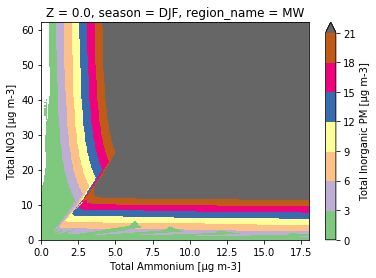

In [10]:
ds_isorropia.sel(region_name = 'MW', season = 'DJF').PM.plot(cmap = 'Accent', levels = np.arange(0,24,3), extend = 'max')


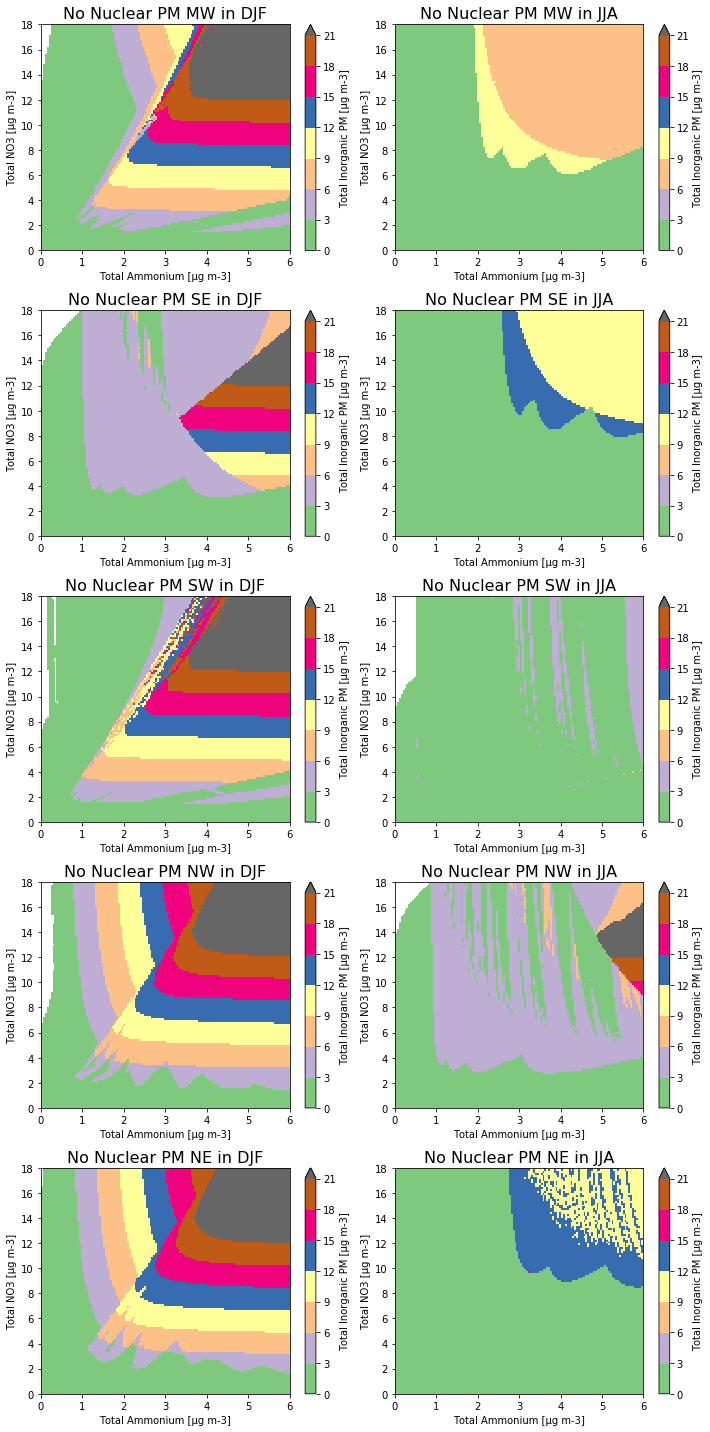

In [179]:
fig, axes = plt.subplots(5,2,figsize = [10,20])
for idx_r, region_name in enumerate(ds_isorropia['region_name'].values):
    for idx_s, season in enumerate(ds_isorropia['season'].values):
        ax = axes[idx_r,idx_s]
        ds_isorropia.sel(region_name = region_name, season = season).PM.plot(ax = ax, cmap = 'Accent', levels = np.arange(0,24,3), extend = 'max', add_colorbar = True)
        ax.set_title(f'No Nuclear PM {region_name} in {season}', fontsize = 16);
        ax.set_xlim(0,6)
        ax.set_ylim(0,18)
        plt.tight_layout()

## Import NIT and SO4 from observations and model

In [92]:
#dict for seasons
season_dict = {'DJF':[12,1,2],'JJA':[6,7,8]}

In [95]:
IMPROVE_obs_df = pd.read_csv('../model_validation/IMPROVE_df.csv', parse_dates = True)
interp_IMPROVE_df = pd.read_csv('../model_validation/interp_IMPROVE_df.csv', parse_dates = True)
IMPROVE_monthly_df = pd.read_csv('../model_validation/IMPROVE_monthly_obs_df.csv', parse_dates = True)
interp_IMPROVE_nonuc_df = pd.read_csv('../model_validation/interp_IMPROVE_nonuc_df.csv', parse_dates = True)

#change to datetime
IMPROVE_obs_df['date'] = pd.to_datetime(IMPROVE_obs_df['Date'], format = '%Y%m%d')
interp_IMPROVE_df['date'] = pd.to_datetime(interp_IMPROVE_df['date'])
IMPROVE_monthly_df['date'] = pd.to_datetime(IMPROVE_monthly_df['date'], format = '%Y%m%d')
interp_IMPROVE_nonuc_df['date'] = pd.to_datetime(interp_IMPROVE_nonuc_df['date'])

#select only Lat and Lon on continental US
IMPROVE_obs_df = IMPROVE_obs_df.loc[(IMPROVE_obs_df['Latitude'].between(24,50,inclusive = True)) & (IMPROVE_obs_df['Longitude'].between(-130,-60,inclusive = True))]
interp_IMPROVE_df = interp_IMPROVE_df.loc[(interp_IMPROVE_df['Latitude'].between(24,50,inclusive = True)) & (interp_IMPROVE_df['Longitude'].between(-130,-60,inclusive = True))]
IMPROVE_monthly_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['latitude'].between(24,50,inclusive = True)) & (IMPROVE_monthly_df['longitude'].between(-130,-60,inclusive = True))]
interp_IMPROVE_nonuc_df = interp_IMPROVE_nonuc_df.loc[(interp_IMPROVE_nonuc_df['Latitude'].between(24,50,inclusive = True)) & (interp_IMPROVE_nonuc_df['Longitude'].between(-130,-60,inclusive = True))]

#modify interpolated model name
interp_IMPROVE_nonuc_df['model'] = 'nonuc'

In [102]:
#modify the IMPROVE monthly df
IMPROVE_monthly_df['model'] = 'IMPROVE'
IMPROVE_monthly_df = IMPROVE_monthly_df.rename(columns = {'latitude':'Latitude','longitude':'Longitude'})

#create a dataframe with the inorganic PM from the obervations
PM_df = IMPROVE_monthly_df.loc[IMPROVE_monthly_df['species'] == 'PM25']
OC_df = IMPROVE_monthly_df.loc[IMPROVE_monthly_df['species'] == 'OC_EC']
inorganic_PM_IMPROVE_df = PM_df.merge(OC_df,
                              indicator=True,
                              how='outer', on = ['geometry','date','Latitude','Longitude', 'Region'])
inorganic_PM_IMPROVE_df['Arithmetic Mean'] = inorganic_PM_IMPROVE_df['Arithmetic Mean_x']- inorganic_PM_IMPROVE_df['Arithmetic Mean_y']
inorganic_PM_IMPROVE_df['species'] = 'inorganic_PM'
inorganic_PM_IMPROVE_df['model'] = 'IMPROVE'
inorganic_PM_IMPROVE_df = inorganic_PM_IMPROVE_df.dropna(axis = 0)

inorganic_PM_IMPROVE_df = inorganic_PM_IMPROVE_df.drop(columns = {'Arithmetic Mean_x','Arithmetic Mean_y','species_x','species_y','_merge','model_x','model_y'})

#join all dataframes
model_obs_df_1 = pd.concat([interp_IMPROVE_df, IMPROVE_monthly_df, inorganic_PM_IMPROVE_df, interp_IMPROVE_nonuc_df])   # CONCATENATE

#find where the NIT data and PM data diverge and get rid of these readings in the PM data
PM_df = inorganic_PM_IMPROVE_df.loc[(inorganic_PM_IMPROVE_df['Region'] == 'NW_lat_lon') & (inorganic_PM_IMPROVE_df['species'] == 'inorganic_PM')]
NIT_df = IMPROVE_monthly_df.loc[(IMPROVE_monthly_df['Region'] == 'NW_lat_lon') & (IMPROVE_monthly_df['species'] == 'NIT')]
comparison_df = NIT_df.merge(PM_df,
                              indicator=True,
                              how='outer', on = ['geometry','date'])
PM_to_delete = comparison_df[comparison_df['_merge'] == 'right_only'].dropna(axis = 1)
PM_to_delete = PM_to_delete.rename(columns = {'Arithmetic Mean_y':'Arithmetic Mean', 'Latitude_y':'Latitude', 'Longitude_y':'Longitude','species_y':'species','Region_y':'Region','annual_T_y':'annual_T','annual_RH_y':'annual_RH','model_y':'model'})
PM_to_delete = PM_to_delete.drop(columns = '_merge')

#drop these values from the dataframe
model_obs_df = pd.concat([model_obs_df_1, PM_to_delete]).drop_duplicates(keep=False)

#modify the PM to just be the inorganic PM form the model runs
for model in ['egrid','NEI','MODEL', 'nonuc']:
    for region in model_obs_df['Region'].unique():
        for season in season_dict.keys():
            model_obs_df.loc[
                (model_obs_df['species'] == 'PM25') & 
                (model_obs_df['model'] == model) & 
                (model_obs_df['Region'] == region) & 
                (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'] = 1.33* (
                model_obs_df.loc[(model_obs_df['species'] == 'NIT') & 
                        (model_obs_df['model'] == model) & 
                        (model_obs_df['Region'] == region) & 
                        (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values + 
                model_obs_df.loc[(model_obs_df['species'] == 'SO4') & 
                    (model_obs_df['model'] == model) & 
                    (model_obs_df['Region'] == region) & 
                    (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values +
                model_obs_df.loc[(model_obs_df['species'] == 'NH4') & 
                    (model_obs_df['model'] == model) & 
                    (model_obs_df['Region'] == region) & 
                    (model_obs_df['date'].dt.month.isin(season_dict[season])), 'Arithmetic Mean'].values)

../plotting.py:410: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


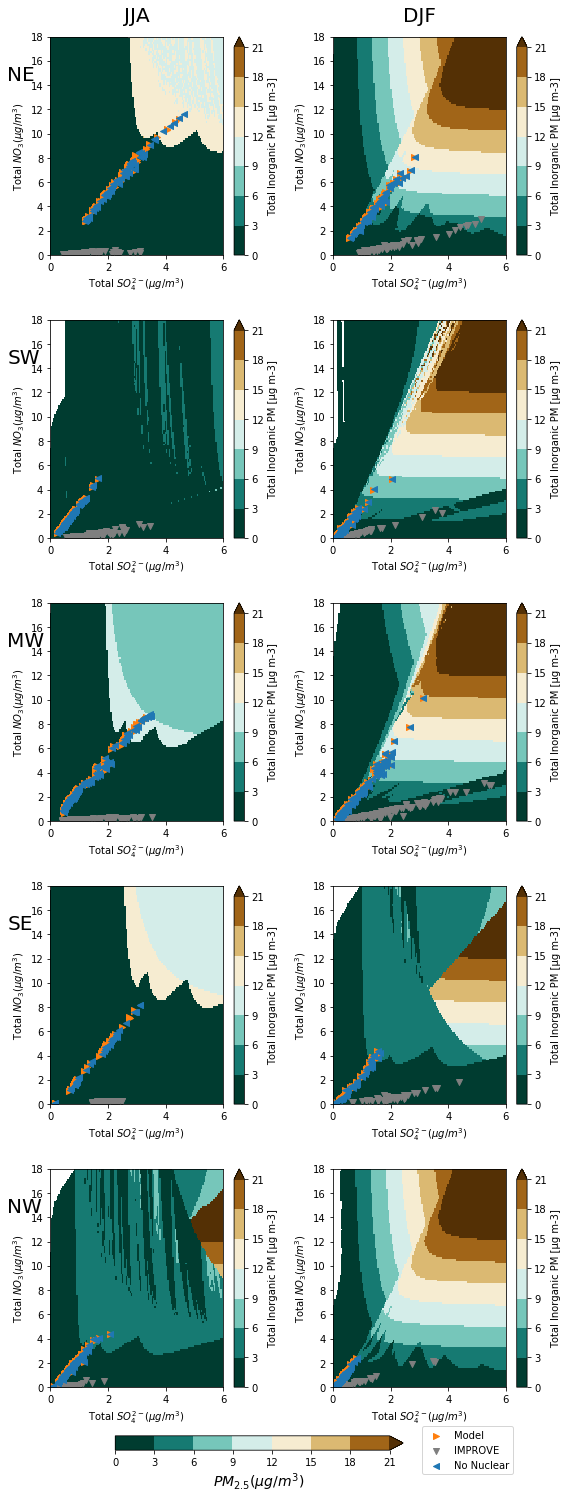

In [109]:
plotting.isorropia_obs_model_plot(model_obs_df, ds_isorropia, vmin = 0, vmax = 24, spacing = 3)
#plt.savefig('./Figures/isorropia_obs_plot.png', bbox_inches = 'tight', dpi = 150)